# Ratchets: One Way Floaters

\text{Coupon payment: } c_i = 
\begin{cases}
    \text{Cap: } c_{i-1} + Y & \text{if } (F_i(T_{i-1}) + X)\tau_i > c_{i-1} + Y, \\
    (F_i(T_{i-1}) + X)\ & \text{if } c_{i-1} \leq (F_i(T_{i-1}) + X)\tau_i \leq c_{i-1} + Y, \\
    \text{Floor: } c_{i-1} & \text{if } (F_i(T_{i-1}) + X)\tau_i < c_{i-1}.
\end{cases}


## Introduction of Ratchets:

A floater (FRN) in which coupon payments are subject to a floor set at the preceding coupon payment and a cap equal to the preceding coupon plus some incremental margin. Coupons on ratchet floaters are typically pegged to LIBOR (3- or 6-month). For example, a ratchet floater may be structured so that it is linked to 6-month LIBOR, while its floor is readjusted on resetting dates with a 20 basis points as incremental margin. Effectively, ratchet floaters deliver a return over time that increases a little bit from period to period, with the coupon payment never dropping below the level of the preceding coupon payment. This type of floater can particularly be instrumental to issuers who expects the implied forward rates would be higher over time, while expecting actual rates to remain above the floor level.

A ratchet floater is also known as a one-way floater.

**Contract specifications**

* The underlyings are $L(T_i, T_{i+6})$ which belongs to the filtration $\mathcal{T}_i$.
* The exercise date is $t = 0$.
* The cash flows are from $T_1$ to $T_\beta$.

Institution A pays to B (a percentage $\gamma$ of) a reference floating rate (plus a constant spread $S$) at dates $T = \{T_1, \ldots, T_\beta\}$. Formally, at time $T_i$ institution A pays to B:
$$(\gamma F_i(T_{i-1}) + S)\tau_i$$

Institution B pays to A a coupon that is given by the reference rate plus a spread $X$ at dates $T$, floored and capped respectively by the previous coupon and by the previous coupon plus an increment $Y$. Formally, at time $T_i$ with $i > 1$, institution B pays to A the coupon:
$$c_i = \begin{cases}
    (F_i(T_{i-1}) + X)\tau_i & \text{if } c_{i-1} \leq (F_i(T_{i-1}) + X)\tau_i \leq c_{i-1} + Y, \\
    c_{i-1} & \text{if } (F_i(T_{i-1}) + X)\tau_i < c_{i-1}, \\
    c_{i-1} + Y & \text{if } (F_i(T_{i-1}) + X)\tau_i > c_{i-1} + Y.
\end{cases}$$

At the first payment time $T_1$, institution B pays to A the coupon $(F_1(T_0) + X)\tau_1$.

The discounted payoff as seen from institution A is
$$
\sum_{i=1}^\beta D\left(0, T_i\right)\left[c_i-\left(\gamma F_i\left(T_{i-1}\right)+S\right) \tau_i\right]
$$
and the value to $\mathrm{A}$ of the contract is the risk-neutral expectation
$$
\begin{aligned}
& E\left\{\sum_{i=1}^\beta D\left(0, T_i\right)\left[c_i-\left(\gamma F_i\left(T_{i-1}\right)+S\right) \tau_i\right]\right\} \\
= & P\left(0, T_\beta\right) \sum_{i=1}^\beta E^\beta\left[\frac{c_i-\left(\gamma F_i\left(T_{i-1}\right)+S\right) \tau_i}{P\left(T_i, T_\beta\right)}\right] .
\end{aligned}
$$
γ = Constant percentage paid by A\
S = Constant Spread paid by A\
X = Constant Spread paid by B\
Y = Constant spread of cap/floor


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

## Building market data

### Importing par yield curve data 

Assuming some data about par yield rates is provided along with the respective maturities 

In [2]:
#import duration for Treasury 
maturities = []

month_to_maturity = [1, 2, 3, 4, 6, 12, 24, 36, 60, 84, 120, 240, 360]



In [3]:
#import Treasury par yield curve rate 
par_yield_curve_rates_ = [5.17, 5.26, 5.39, 5.39, 5.41, 5.24, 4.68, 4.29, 3.96, 3.85, 3.74, 4.01, 3.83]

#transfer semiannual rates to annual rates
par_yield_curve_rates = []

for i in par_yield_curve_rates_:
    r = (1+i/200)**2-1
    par_yield_curve_rates.append(r*100)


Text(0.5, 1.0, 'Market Data')

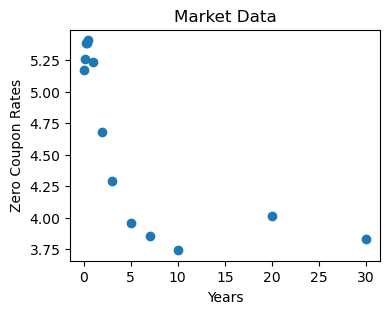

In [4]:
plt.figure(figsize = (4,3))
plt.scatter([i/12 for i in month_to_maturity], par_yield_curve_rates_)
plt.xlabel('Years')
plt.ylabel('Zero Coupon Rates')
plt.title('Market Data')

### Interpolating yield curve

* Linear Interpolation
* LogLinearInterpolation
* CubicNaturalSpline
* LogCubicNaturalSpline


In [5]:
from QuantLib import *

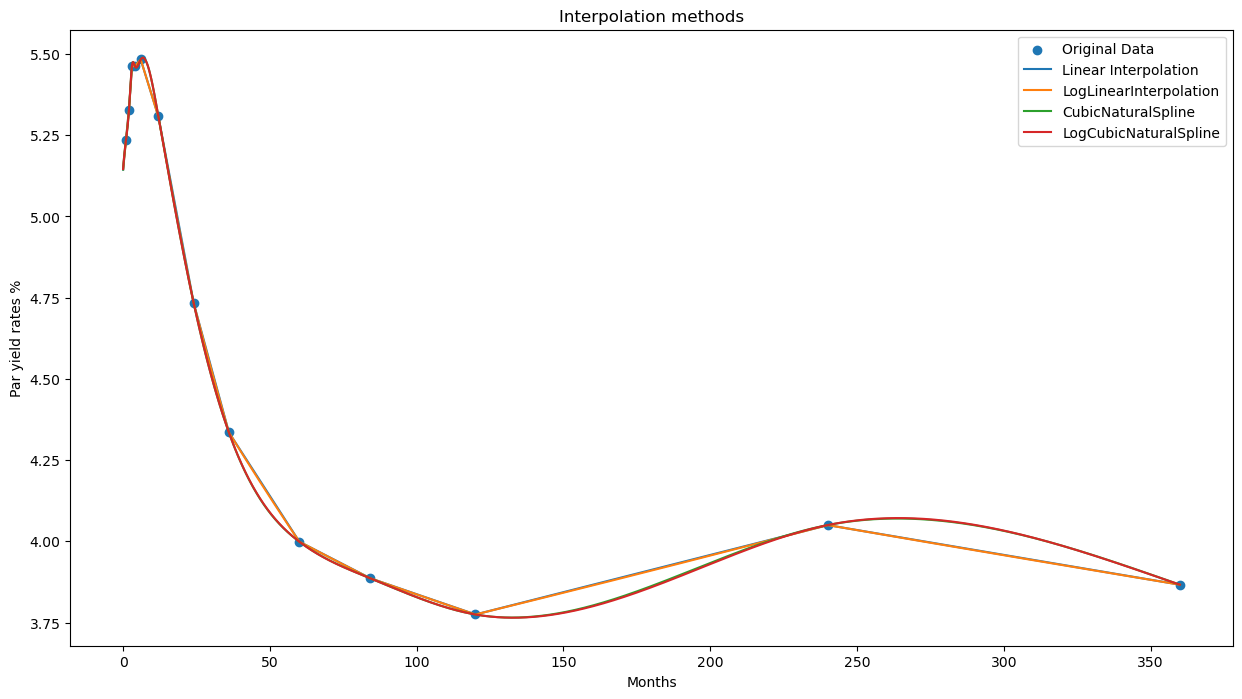

In [6]:
#apply interpolation method(Linear Interpolation,LogLinearInterpolation, CubicNaturalSpline, LogCubicNaturalSpline)
methods = {
    'Linear Interpolation': LinearInterpolation(month_to_maturity, par_yield_curve_rates),
    'LogLinearInterpolation': LogLinearInterpolation(month_to_maturity, par_yield_curve_rates),
    'CubicNaturalSpline': CubicNaturalSpline(month_to_maturity, par_yield_curve_rates),
    'LogCubicNaturalSpline': LogCubicNaturalSpline(month_to_maturity, par_yield_curve_rates),
    }

#interpolate 30 years rates to get 10800 days rates(assume 360 days a year) 
xx = np.linspace(0,360,10800)

#plot original data
fig = plt.figure(figsize=(15,8))
plt.scatter(month_to_maturity, par_yield_curve_rates, label='Original Data')

yy = {}

#plot results from different interpolation methods
for name, i in methods.items():
    yy[name] = [i(x, allowExtrapolation=True) for x in xx]
    plt.plot(xx, yy[name], label=name)
    
plt.title('Interpolation methods')
plt.xlabel('Months')
plt.ylabel('Par yield rates %')
plt.legend()
plt.show()


In [7]:
#set up testing data

#increase one base point on first month rate to see how forward rate changes: 5.17 -> 5.18
par_yield_curve_rates_test_ = [5.18, 5.26, 5.39, 5.39, 5.41, 5.24, 4.68, 4.29, 3.96, 3.85, 3.74, 4.01, 3.83]

#transfer semiannual rates to annual rates
par_yield_curve_rates_test = []
for i in par_yield_curve_rates_test_:
    r = (1+i/200)**2-1
    par_yield_curve_rates_test.append(r*100)
    

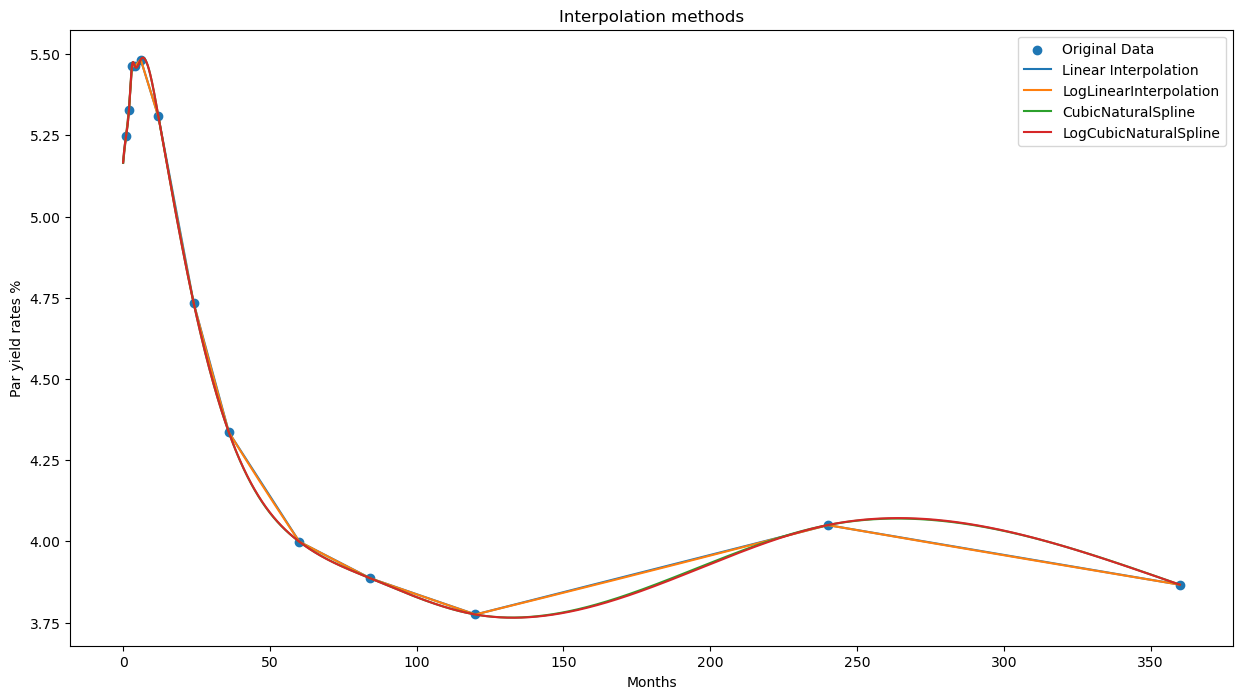

In [8]:
#apply interpolation methods on testing data
methods_test = {
    'Linear Interpolation': LinearInterpolation(month_to_maturity, par_yield_curve_rates_test),
    'LogLinearInterpolation': LogLinearInterpolation(month_to_maturity, par_yield_curve_rates_test),
    'CubicNaturalSpline': CubicNaturalSpline(month_to_maturity, par_yield_curve_rates_test),
    'LogCubicNaturalSpline': LogCubicNaturalSpline(month_to_maturity, par_yield_curve_rates_test),
    }

xx_test = np.linspace(0,360,10800)

#plot original testing data
fig = plt.figure(figsize=(15,8))
plt.scatter(month_to_maturity, par_yield_curve_rates_test, label='Original Data')

yy_test = {}

#plot results from different interpolation methods on testing data
for name, i in methods_test.items():
    yy_test[name] = [i(x, allowExtrapolation=True) for x in xx_test]
    plt.plot(xx_test, yy_test[name], label=name)
    
plt.title('Interpolation methods')
plt.xlabel('Months')
plt.ylabel('Par yield rates %')
plt.legend()
plt.show()


In [9]:
#get instantaneous forward rates from different interpolation methods 
#f(t) = r(t) + r'(t) * t
forward_rate = {'Linear Interpolation':[], 'LogLinearInterpolation':[], 'CubicNaturalSpline':[], 'LogCubicNaturalSpline':[]}

for name, i in forward_rate.items():
    for j in range(1, len(yy[name])):
        forward_rate[name].append(yy[name][j-1] + (yy[name][j]-yy[name][j-1]) / (xx[j]-xx[j-1]) * ((j-1)/360))
       

In [10]:
#get instantaneous forward rates from different interpolation methods on testing data 
forward_rate_test = {'Linear Interpolation':[], 'LogLinearInterpolation':[], 'CubicNaturalSpline':[], 'LogCubicNaturalSpline':[]}

for name, i in forward_rate_test.items():
    for j in range(1, len(yy_test[name])):
        forward_rate_test[name].append(yy_test[name][j-1] + (yy_test[name][j]-yy_test[name][j-1]) / (xx[j]-xx[j-1]) * ((j-1)/360))


<Figure size 1500x800 with 0 Axes>

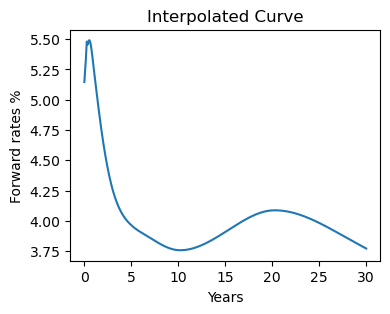

In [11]:
#plot forward curve 
fig = plt.figure(figsize=(15,8))

plt.figure(figsize = (4,3))
plt.plot([i/12 for i in xx[:-1]], forward_rate['LogCubicNaturalSpline'])
plt.title('Interpolated Curve')
plt.xlabel('Years')
plt.ylabel('Forward rates %')

plt.show()


#### Testing the Interpolation Methods 

Condotion for better interpolation methods:

* Forward rates curve above 0

* Minimum basis point change in the forward curve given some basis point change (up or down) in one of the inputs

In [12]:
#calculate the minimum value for forward rates in different interpolation methods   

#condition for better interpolation methods: 
#1. forward rates curve above 0

#minimum value for forward rates curve 
for name, i in forward_rate.items():
    print('minimum value of forward rate for', name, 'is', min(forward_rate[name]))
    

minimum value of forward rate for Linear Interpolation is 3.7440239403616946
minimum value of forward rate for LogLinearInterpolation is 3.744473492574544
minimum value of forward rate for CubicNaturalSpline is 3.7589096246710687
minimum value of forward rate for LogCubicNaturalSpline is 3.7585755048442353


Forward rates in all methods are  above 0 

In [13]:
#2. Minimum basis point change in the forward curve given some basis point change (up or down) in one of the inputs¶

#forward rates change for one base point change on interest rates in each interpolation methods 
for name, i in forward_rate.items():
    print('max change in', name, max(forward_rate_test[name][j] - forward_rate[name][j] for j in range(len(forward_rate[name]))))
    

max change in Linear Interpolation 0.02051750000000574
max change in LogLinearInterpolation 0.020181709843686058
max change in CubicNaturalSpline 0.02051750000000574
max change in LogCubicNaturalSpline 0.020181709843686058


**LogCubicNaturalSpline method has the minimum change**

**Decision:  LogCubicNaturalSpline to be used for interpolation**

In [17]:
#interest rate 
yield_rates = [i/100 for i in yy['LogCubicNaturalSpline']]

### Calculating Zero Coupon Bond Price P(0,t)

In [18]:
#calculate zero coupon bond price P(0,t), $1 on maturity date
P_0 = []

for t in range(len(yield_rates)):
    p = 1/((1+yield_rates[t])**(t/360))
    P_0.append(p)


Text(0.5, 1.0, 'Zero bond Curve')

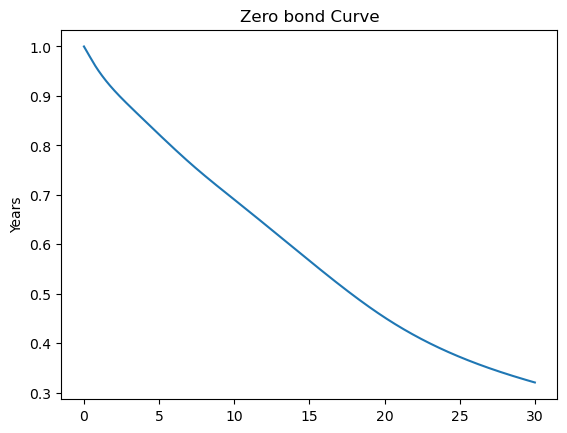

In [19]:
plt.plot([i/360 for i in range(0,10800)],P_0)
plt.ylabel('Years')
plt.title('Zero bond Curve')

### Calculating the instantaneous forward rate

In [20]:
#calculate instantaneous forward rates, f(0,t)
f_0 = [0.05]   
for t in range(1, len(P_0)):
    f = (-np.log(P_0[t]) + np.log(P_0[t-1]))/(1/360)
    f_0.append(f)
    

Text(0.5, 1.0, 'Instantaneous forward rate')

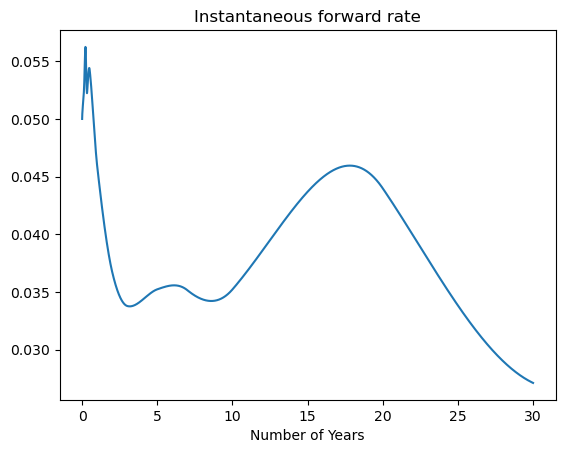

In [21]:
plt.plot([i/360 for i in range(0, 10800)],f_0)
plt.xlabel('Number of Years') 
plt.title('Instantaneous forward rate')

In [22]:
#calculate zero coupon bond price P(0,t), $1 on maturity date
P_0 = []

for t in range(len(yield_rates)):
    p = 1/((1+yield_rates[t])**(t/360))
    P_0.append(p)  


Text(0.5, 1.0, 'Zero bond Curve')

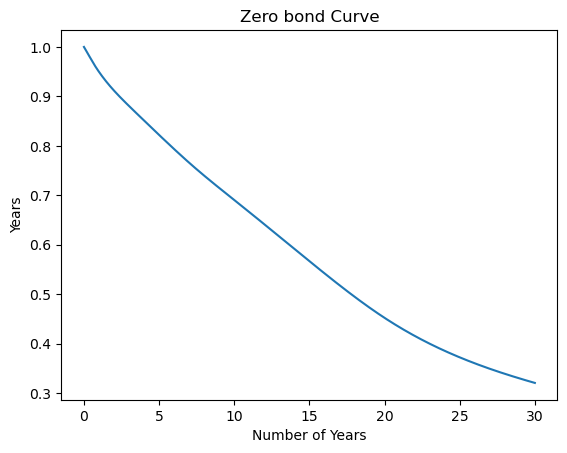

In [23]:
plt.plot([i/360 for i in range(0,10800)],P_0)
plt.ylabel('Years')
plt.xlabel('Number of Years') 
plt.title('Zero bond Curve')

## G2++ short rate model

### Calculating instantaneous short rate

Defining initial model parameteres

In [82]:
a = 0.0002  # Mean reversion speed for x
b = 0.0002  # Mean reversion speed for y
sigma = 0.00050  # Volatility of x
eta = 0.00050  # Volatility of y
rho = -0.9  # Instantaneous correlation



$$
r(t)=x(t)+\varphi(t), \quad r(0)=r_0,
$$
where the processes $\{x(t): t \geq 0\}$ satisfies
$$
\begin{aligned}
& d x(t)=-a x(t) d t+\sigma d W_1(t), x(0)=0 \\
\end{aligned}
$$
where $\left(W_1, W_2\right)$ is a two-dimensional Brownian motion with instantaneous correlation $\rho$ as from
$$
d W_1(t) d W_2(t)=\rho d t
$$

We assume that the dynamics of the instantaneous-short-rate process under the risk-adjusted measure $Q$ is given by
$$
r(t)=x(t)+y(t)+\varphi(t), \quad r(0)=r_0,
$$
where the processes $\{x(t): t \geq 0\}$ and $\{y(t): t \geq 0\}$ satisfy
$$
\begin{aligned}
& d x(t)=-a x(t) d t+\sigma d W_1(t), x(0)=0, \\
& d y(t)=-b y(t) d t+\eta d W_2(t), \quad y(0)=0,
\end{aligned}
$$
where $\left(W_1, W_2\right)$ is a two-dimensional Brownian motion with instantaneous correlation $\rho$ as from
$$
d W_1(t) d W_2(t)=\rho d t
$$

\begin{aligned}
E^{Q^T}\left\{r(t) \mid \mathcal{F}_s\right\}= & x(s) e^{-a(t-s)}-M_x^T(s, t)+y(s) e^{-b(t-s)}-M_y^T(s, t)+\varphi(t), \\
\operatorname{Var}^{Q^T}\left\{r(t) \mid \mathcal{F}_s\right\}= & \frac{\sigma^2}{2 a}\left[1-e^{-2 a(t-s)}\right]+\frac{\eta^2}{2 b}\left[1-e^{-2 b(t-s)}\right] \\
& +2 \rho \frac{\sigma \eta}{a+b}\left[1-e^{-(a+b)(t-s)}\right]
\end{aligned}

\begin{aligned}
M_x^T(s, t)= & \left(\frac{\sigma^2}{a^2}+\rho \frac{\sigma \eta}{a b}\right)\left[1-e^{-a(t-s)}\right]-\frac{\sigma^2}{2 a^2}\left[e^{-a(T-t)}-e^{-a(T+t-2 s)}\right] \\
& -\frac{\rho \sigma \eta}{b(a+b)}\left[e^{-b(T-t)}-e^{-b T-a t+(a+b) s}\right], \\
M_y^T(s, t)= & \left(\frac{\eta^2}{b^2}+\rho \frac{\sigma \eta}{a b}\right)\left[1-e^{-b(t-s)}\right]-\frac{\eta^2}{2 b^2}\left[e^{-b(T-t)}-e^{-b(T+t-2 s)}\right] \\
& -\frac{\rho \sigma \eta}{a(a+b)}\left[e^{-a(T-t)}-e^{-a T-b t+(a+b) s}\right],
\end{aligned}

In [25]:
#define mean x
def M_x(s, t,T):
  return ((sigma**2/a**2)+(rho*sigma*eta/(a*b)))*(1 - np.exp(-a*(t-s))) -  ((sigma**2/(2*a**2))* (np.exp(-a*(T-t)) - np.exp(-a*(T+t-2*s)))) - (rho*sigma*eta/(b*(a+b))*(np.exp(-b*(T-t)) - np.exp(-b*T - a*t + (a+b)*s)))

#define mean y
def M_y(s, t,T):
  return ((eta**2/b**2)+(rho*sigma*eta/(a*b)))*(1 - np.exp(-b*(t-s))) -  ((sigma**2/(2*b**2))* (np.exp(-b*(T-t)) - np.exp(-b*(T+t-2*s)))) - (rho*sigma*eta/(a*(a+b))*(np.exp(-a*(T-t)) - np.exp(-a*T - b*t + (a+b)*s)))


In [26]:
#define variance x
def V_x(s, t):
  return (sigma**2)*(1-np.exp(-2*a*(t-s)))/(2*a)

#define variance y
def V_y(s, t):
  return (eta**2)*(1-np.exp(-2*b*(t-s)))/(2*b)

#define covariance
def Cov_xy(s,t):
  return (2*sigma*eta*rho)*(1-np.exp(-(a+b)*(t-s)))/(a+b)


In [27]:
def xy(t):
   # Parameters for the univariate distributions
    t=t
    s=0
    T = t + 1
    # T=t+30
    mean_1 = M_x(s,t,T)
    mean_2 = M_y(s,t,T)
    variance_1 = V_x(s,t)
    variance_2 = V_y(s,t)
    covariance = Cov_xy(s,t)
    # print(variance_1,variance_2)
    # Number of data points to generate
    num_samples = 1

    # Generate samples from the bivariate normal distribution
    mean_vector = np.array([mean_1, mean_2])
    cov_matrix = np.array([[variance_1, covariance], [covariance, variance_2]])
    x,y = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples).T
    return x[0],y[0]


$$
\begin{aligned}
\varphi(T) = f^M(0, T) + \frac{\sigma^2}{2 a^2}\left(1-e^{-a T}\right)^2 + \frac{\eta^2}{2 b^2}\left(1-e^{-b T}\right)^2 + \rho \frac{\sigma \eta}{a b}\left(1-e^{-a T}\right)\left(1-e^{-b T}\right)
\end{aligned}
$$


In [28]:
def phi(t):
    phi = f_0[int(t*360)-1] + ((sigma**2)/(2*a**2))*((1-np.exp(-a*t))**2) + (eta**2)/(2*b**2)*((1-np.exp(-b*t))**2) + (rho*sigma*eta)/(a*b)*((1-np.exp(-a*t))*(1-np.exp(-b*t)))
    # print('phi',phi)
    return(phi)

Instantaneous spot rate in the risk neutral measure
$$
r(t)=x(t)+y(t)+\varphi(t), \quad r(0)=r_0,
$$

In [29]:
def spot(t):
    global xt, yt
    x,y = xy(t)
    spot = x + y + phi(t)
    xt,yt=x,y
    # print(x,y,phi(t))
    return spot

### Pricing zero coupon bond using G2++

$\begin{aligned} V(t, T)= & \frac{\sigma^2}{a^2}\left[T-t+\frac{2}{a} e^{-a(T-t)}-\frac{1}{2 a} e^{-2 a(T-t)}-\frac{3}{2 a}\right] \\ & +\frac{\eta^2}{b^2}\left[T-t+\frac{2}{b} e^{-b(T-t)}-\frac{1}{2 b} e^{-2 b(T-t)}-\frac{3}{2 b}\right] \\ & +2 \rho \frac{\sigma \eta}{a b}\left[T-t+\frac{e^{-a(T-t)}-1}{a}+\frac{e^{-b(T-t)}-1}{b}-\frac{e^{-(a+b)(T-t)}-1}{a+b}\right]\end{aligned}$

In [30]:
def V(t,T):
    V = (sigma**2 /(a**2))*(T-t+(2*np.exp(-a*(T-t)))/a - (np.exp(-2*a*(T-t)))/(2*a) - 1.5/a) +\
        (eta/b)**2*(T-t + 2*np.exp(-b*(T-t))/b - np.exp(-2*b*(T-t))/(2*b) - 1.5/b ) + \
        (2*rho*sigma*eta/(a*b))*(T-t + (np.exp(-a*(T-t))-1)/a + (np.exp(-b*(T-t))-1)/b - (np.exp(-(a+b)*(T-t))-1)/(a+b))
    # print(V)
    return V

$\begin{aligned} \mathcal{A}(t, T):= & \frac{1}{2}[V(t, T)-V(0, T)+V(0, t)] \\ & -\frac{1-e^{-a(T-t)}}{a} x(t)-\frac{1-e^{-b(T-t)}}{b} y(t) .\end{aligned}$

In [31]:
def A(t,T):
    A = 0.5*(V(t,T) - V(0,T) + V(0,t)) - ((1-np.exp(-a*(T-t)))*xt/a) - ((1-np.exp(-b*(T-t)))*yt/b)
    # print(A,xt,yt,V(t,T),V(0,T),V(0,t))
    return A

$P(t, T)=\frac{P^M(0, T)}{P^M(0, t)} \exp \{\mathcal{A}(t, T)\}$

In [33]:
def P(t,T):
    if T ==0:
        T=0.01
    T_day = int(T*360)  #P_0 is represented in days
    t_day = int(t*360)
    # print(T_day,T)
    P = (P_0[T_day-1]/P_0[t_day])*np.exp(A(t,T))
    # print(P_0[T_day-1],np.exp(A(t,T)), A(t,T))
    return P

### Calculating the simply compounded forward interest rate F(t,T,S)

Calculating the 6 month zero coupon bond rate as a proxy for 6 month LIBOR which is the floating rate in the derivative
Definition 1.4.1. Simply-compounded forward interest rate. The simply-compounded forward interest rate prevailing at time t for the expiry $T>t$ and maturity $S>T$ is denoted by $F(t ; T, S)$ and is defined by
$$
F(t ; T, S):=\frac{1}{\tau(T, S)}\left(\frac{P(t, T)}{P(t, S)}-1\right)
$$


In [34]:
def F(t,T,S):
    tau = T-S
    F = (P(t,T)/P(t,S)-1)/tau
    return F

### Testing G2++ model

In [77]:
def path():
    global spot_list
    global zc_list
    global f_list
    spot_list = []
    zc_list = []
    f_list = []
    for i in range(0,10800):
        # print(i)
        spot_list.append(spot(i/360))
        zc_list.append(P(0,i/360))
        if i%180 == 0 and i <10440:
            # print(i)
            f_list.append(F(i/360,i/360+0.5,i/360+1.5))


In [83]:
path()

/tmp/ipykernel_79639/1142869060.py:19: RuntimeWarning: covariance is not positive-semidefinite.
  x,y = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples).T


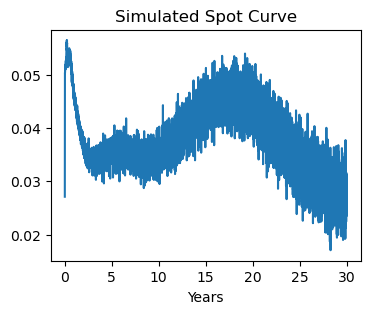

In [84]:
# spot_list = []
# spot_list.append([spot(i/360) for i in range(0, 10800)])  # Use i/360 as the x-values for years
plt.figure(figsize = (4,3))
plt.plot([i/360 for i in range(0, 10800)], spot_list)  # Use i/360 for x-axis to display in years
plt.xlabel('Years')  # Update the x-axis label
plt.title('Simulated Spot Curve')  # Update the title
plt.show()


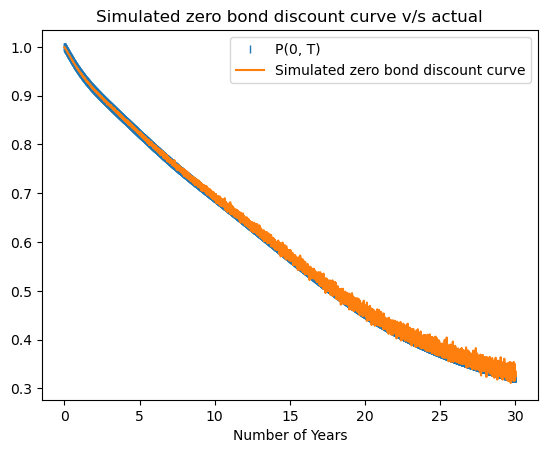

In [81]:
plt.plot([i/360 for i in range(0, 10800)],P_0, '|', label='P(0, T)')
plt.plot([i/360 for i in range(0, 10800)],zc_list,  label='Simulated zero bond discount curve')
plt.title('Simulated zero bond discount curve v/s actual')
plt.xlabel('Number of Years')
plt.legend()

# plt.plot(P_0, color='orange')

## Pricing the derivative

### Coupon calculation

Defining function to calculate coupons


$$c_i = \begin{cases}
    (F_i(T_{i-1}) + X)\tau_i & \text{if } c_{i-1} \leq (F_i(T_{i-1}) + X)\tau_i \leq c_{i-1} + Y, \\
    c_{i-1} & \text{if } (F_i(T_{i-1}) + X)\tau_i < c_{i-1}, \\
    c_{i-1} + Y & \text{if } (F_i(T_{i-1}) + X)\tau_i > c_{i-1} + Y.
\end{cases}$$


In [61]:
def ci(ci_minus_1, Fi_Ti_minus_1,X,Y, tau_i = 0.5):
    ci = None
    calculated_value = (Fi_Ti_minus_1 + X) * tau_i

    if ci_minus_1 <= calculated_value <= ci_minus_1 + Y:
        ci = calculated_value
    elif calculated_value < ci_minus_1:
        ci = ci_minus_1
    else:
        ci = ci_minus_1 + Y

    return ci


the value to $\mathrm{A}$ of the contract is the risk-neutral expectation
$$
\begin{aligned}
& E\left\{\sum_{i=1}^\beta D\left(0, T_i\right)\left[c_i-\left(\gamma F_i\left(T_{i-1}\right)+S\right) \tau_i\right]\right\} \\
= & P\left(0, T_\beta\right) \sum_{i=1}^\beta E^\beta\left[\frac{c_i-\left(\gamma F_i\left(T_{i-1}\right)+S\right) \tau_i}{P\left(T_i, T_\beta\right)}\right] .
\end{aligned}
$$
γ = Constant percentage paid by A\
S = Constant Spread paid by A\
X = Constant Spread paid by B\
Y = Constant spread of cap/floor


Contract Specific definitions

First coupon payment by B to A is the first element of the coupon list
$(F_1(T_0) + X)\tau_1$.

### Expected Value

Pricing function

In [159]:
def EV(beta, S,gamma,X,Y):
    beta = beta #Time period
    S= S #Constant spread paid by A
    gamma = gamma #Constant percentage paid by A
    X = X #Constant spread paid by B
    Y = Y #Constant spread of the cap/floor
    # F_list = []
    ci_list = []
    num = beta*2
    time_steps = [i for i in range(0,num)]
    time_steps.append(beta*2)

    # for i in time_steps:
        # ci_list.append()
    #     # print(str(i) + "Time step of failure")
    #     F_list.append(F(i,i+1,i+2)) #corresponding 6m Libor at every time step
     
    ci_list = [(f_list[0]+X)*0.5] # First coupon payment by B to A   
    EV = 0
    for i in time_steps:
        # print(str(i) + "Time step of failure")
        Fi_Ti_minus_1 = f_list[i-1]
        ci_list.append(ci(ci_list[i-1],Fi_Ti_minus_1,X,Y))
        EV += (ci_list[i] - (gamma*Fi_Ti_minus_1 + S)*0.5)/P(i,beta)
    # return EV*P(0,beta)
    return EV*10000000

In [160]:
# f_plot = []
# c_plot = []
# # for i in time_steps:
# #     f_plot.append(F(i,i+1,i+2))
# beta =3
# num = beta*2
# time_steps = [i for i in range(0,num)]
# time_steps.append(beta*2)
# c_plot = [(F(0,0.5,1.5)+0.05)*0.5] # First coupon payment by B to A   
# for i in time_steps:
#     c_plot.append(ci(ci_list[i-1],Fi_Ti_minus_1))
# plt.plot(c_plot)
# plt.plot(f_plot)

In [161]:
EV(beta=10,#Time period
   S=-0.0,#Constant spread paid by A
   gamma=0.1,#Constant percentage paid by A
   X=0.03, #Constant spread paid by B
   Y=0.00005 #Constant spread of the cap/floor
  )

-1451346.210272516

Monte carlo of the result

In [162]:
n = 100 #number of simulations

/tmp/ipykernel_79639/1142869060.py:19: RuntimeWarning: covariance is not positive-semidefinite.
  x,y = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples).T


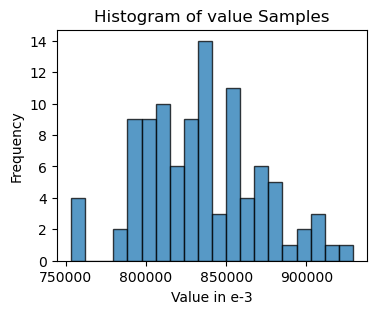

Standard Deviation: 36219.367874
Mean: 834617.674193
Thus, the value of the contract to A is: $834617.674193


In [164]:
# Run the EV function n times and store the results in EV_samples list
EV_samples = []
for i in range(n):
    path()
    EV_samples.append(
        EV(beta=3, S=0.02, gamma=0.8, X=0.05, Y=0.7)
    )


# Plot the histogram of the result
plt.figure(figsize = (4,3))
plt.hist(np.round(EV_samples,6), bins=20, edgecolor='black', alpha=0.75)
plt.xlabel('Value in e-3')
plt.ylabel('Frequency')
plt.title('Histogram of value Samples')
plt.show()

# Print the standard deviation and mean
std_dev = np.std(EV_samples)
mean_value = np.mean(EV_samples)
print(f'Standard Deviation: {std_dev:.6f}')
print(f'Mean: {mean_value:.6f}')
print(f'Thus, the value of the contract to A is: ${mean_value:.6f}')

### Testing the pricing engine

In [167]:
pltpoints = []
for i in range (0,10):
    pltpoints.append(EV(beta=i, S=0.02, gamma=0.8, X=0.05, Y=0.7
  ))

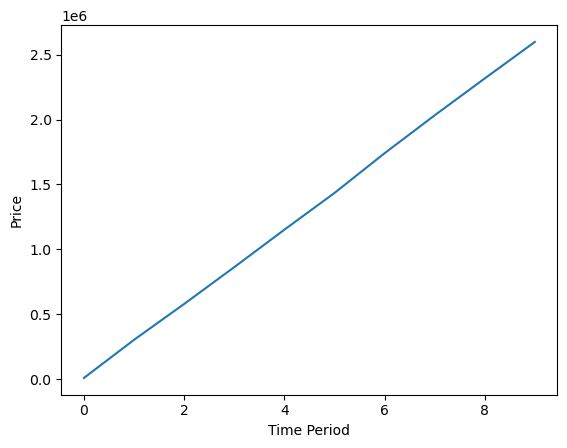

In [168]:
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.plot(pltpoints)

In [208]:
pltpoints = []
for i in np.linspace(0,1,100000):
    pltpoints.append([i,EV(beta=3, S=i #constant spread by A
                        , gamma=0.8, X=0.05, Y=0.7
  )])

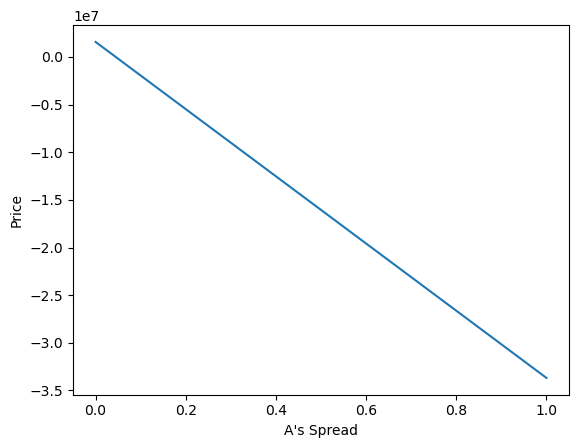

In [209]:
pltpoints = pd.DataFrame(pltpoints)
plt.xlabel("A's Spread")
plt.ylabel('Price')
plt.plot(pltpoints.iloc[:,0],pltpoints.iloc[:,1])

In [203]:
pltpoints = []
for i in np.linspace(0,1,100000):
    pltpoints.append([i,EV(beta=3, S=0.02 #constant spread by A
                        , gamma=0.8, X=i#Constant spread paid by B
                        , Y=0.7
  )])

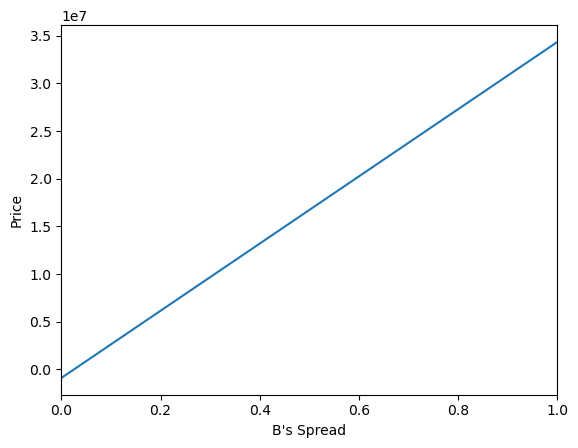

In [205]:
pltpoints = pd.DataFrame(pltpoints)
plt.xlabel("B's Spread")
plt.ylabel('Price')
plt.xlim(0,1)
plt.plot(pltpoints.iloc[:,0],pltpoints.iloc[:,1])

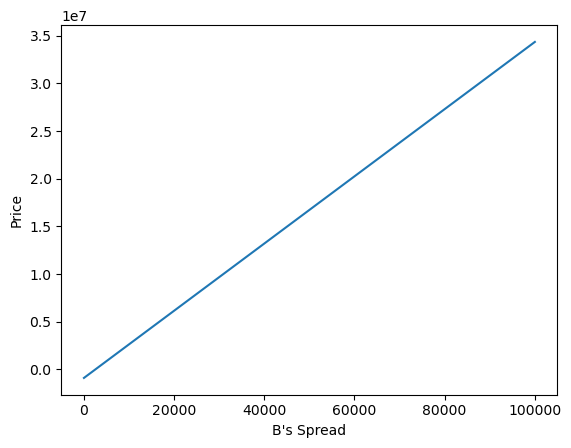

In [177]:
plt.xlabel("B's Spread")
plt.ylabel('Price')
plt.plot(pltpoints)

In [185]:
pltpoints = []
for i in np.linspace(0,1,100000):
    pltpoints.append([i,EV(beta=3, S=0.02 #constant spread by A
                        , gamma=i #percentage of Floating rate for A
                        , X=0.01 #Constant spread paid by B
                        , Y=0.7
  )])
   # print(i)

In [186]:
len(pltpoints)

100000

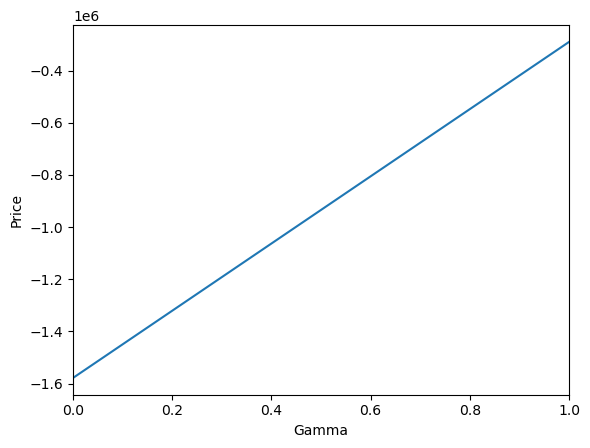

In [198]:
pltpoints = pd.DataFrame(pltpoints)
plt.xlabel("Gamma")
plt.ylabel('Price')
plt.xlim(0,1)
plt.plot(pltpoints.iloc[:,0],pltpoints.iloc[:,1])

In [193]:
pltpoints[0]

[0.0, -1578600.3557408499]

In [217]:
pltpoints = []
for i in np.linspace(0,0.075,100000):
    pltpoints.append([i,EV(beta=3, S=0.02 #constant spread by A
                        , gamma=0.8, X=0.01#Constant spread paid by B
                        , Y=i
  )])

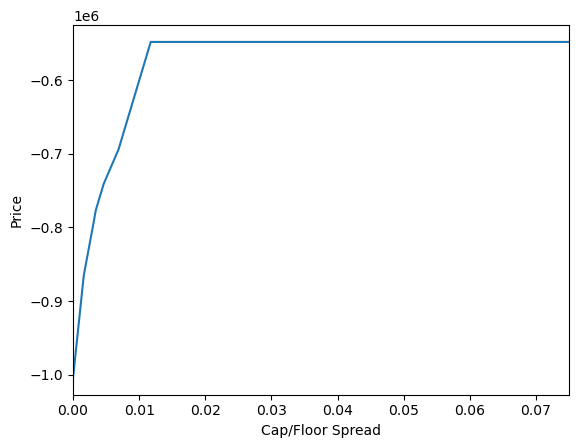

In [219]:
pltpoints = pd.DataFrame(pltpoints)
plt.xlabel("Cap/Floor Spread")
plt.ylabel('Price')
plt.xlim(0,0.075)
plt.plot(pltpoints.iloc[:,0],pltpoints.iloc[:,1])